In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
pd.set_option('display.max_columns', None)

# Renaming Demographics Columns

In [2]:
demo = pd.read_csv('demographics.csv', sep = ';')
#extract the numbers out of the participantID: input: 'p12'; output: '12'
demo['participantID'] = demo.apply(lambda row:  int(re.findall('\d*', row['SD03_01'])[1]), axis=1)
#sort by participant ID. Not all results were submitted in the order they were carried out
demo = demo.sort_values(by=['participantID'])
demo = demo[['participantID', 'E001', 'E002', 'E003', 'E004', 'E005', 'E006', 'SD01', 'SD02_01', 'SD04']]
demo = demo.rename(columns={'E001' : 'How often do you use VR? At least once a...', 
                            'E002' : 'How experienced do you feel when you are using VR?',
                            'E003' : 'Have you used VR Controllers before to interact in a VR environment?',
                            'E004' : 'Have you used VR Controllers before to move or pick up objects in a VR environment?',
                            'E005' : 'Have you used finger tracking before to interact in a VR environment? (eg. a glove, optical finger tracking)',
                            'E006' : 'Have you used finger tracking before to move or pick up objects in a VR environment? (eg. a glove, optical finger tracking)',
                            'SD01' : 'What is your gender?',
                            'SD02_01' : 'How old are you?',
                            'SD04' : 'What is your dominant hand?'})
# drop the last two participants that didn't go through the same experiment
demo = demo[demo.participantID <= 21]
# Save the clean version
demo.to_csv('demo_clean.csv', sep = ';')
demo

participantID How often do you use VR? At least once a...  \
0               1                 I have never used VR before   
1               2                                        year   
21              3                                        year   
22              4                                        year   
2               5                                        year   
3               6                                        year   
4               7                                        year   
5               8                                       month   
6               9                 I have never used VR before   
7              10                 I have never used VR before   
8              11                 I have never used VR before   
9              12                                        year   
10             13                                        week   
11             14                                        year   
12             15                 I have never used VR before   
13             16                                        year   
14             17                 I have never used VR before   
15             18                 I have never used VR before   
16             19                 I have never used VR before   
17             20                 I have never used VR before   
18             21                                        year   

   How experienced do you feel when you are using VR?  \
0                              Not experienced at all   
1                              Not experienced at all   
21                                 Little experienced   
22                             Not experienced at all   
2                              Moderately experienced   
3                                  Little experienced   
4                              Moderately experienced   
5                                  Little experienced   
6                                  Little experienced   
7                              Not experienced at all   
8                              Not experienced at all   
9                                  Little experienced   
10                                   Very experienced   
11                                 Little experienced   
12                             Not experienced at all   
13                             Moderately experienced   
14                             Not experienced at all   
15                             Not experienced at all   
16                             Not experienced at all   
17                             Not experienced at all   
18                                 Little experienced   

   Have you used VR Controllers before to interact in a VR environment?  \
0                                                  No                     
1                                                 Yes                     
21                                                Yes                     
22                                                Yes                     
2                                                  No                     
3                                                  No                     
4                                                 Yes                     
5                                                 Yes                     
6                                                  No                     
7                                                  No                     
8                                                  No                     
9                                                 Yes                     
10                                                Yes                     
11                                                Yes                     
12                                                 No                     
13                                                Yes                     
14                                         

# Helper Function

In [3]:
#Will merge dataframes by ID and Item name so each row contains data 
def mergePairwise(df, merge_on=["participantID"], split_by='Mode'):
    #do some cheap edge case checking
    if(split_by not in df.columns):
        raise Exception('Dataframe needs the Column ' + split_by + ' with either \'Binary\' or \'Fixed\' as values! And \'ID\' and \'Item_name\' as well.')
    
    # create tables only containing rows from one condition
    fixed = df.query(split_by + ' == "Fixed"')
    binary = df.query(split_by + ' == "Binary"')

    # merge all samples on item name and participant ID and save as csv
    paired_fixed_binary = pd.merge(fixed, binary, on=merge_on, suffixes = ('_fixed','_binary'))#
    
    # rename column
    paired_fixed_binary = paired_fixed_binary.rename(columns=
               {'Task_Order_fixed' : 'Task_Order',
                'Condition_Order_fixed' : 'Condition_Order'})
    
    # remove redundant information
    paired_fixed_binary = paired_fixed_binary.drop([(split_by + '_fixed'),
                                                    (split_by + '_binary'),
                                                     'Task_Order_binary',
                                                     'Condition_Order_binary'], axis = 1)
    return paired_fixed_binary
 

# Cleaning up the custom questions

In [4]:
# import cstm
cstm = pd.read_csv('questionnaireID_custom_ALL_answers.csv', sep = ';') 
# rotate so each row represents answers for one condition from one participant
cstm = cstm.transpose()
cstm = cstm.drop(['QuestionType', 'QuestionID']) #Delete multiple header rows
cstm.set_axis(cstm.iloc[0], axis=1, inplace = True) #take first row and set as header ; DEBUG: tells to use copy = false instead of the inplace keyword, which causes trouble with replacing the characters. It seems like the trick to gaether the column names doesn' t work anymore
cstm = cstm.drop(['Question']) # can only be dropped after the previous step
cstm = cstm.astype(int)
# rename columns (removes some formatting which was done for the VR Questionnaire)
cstm.columns = cstm.columns.str.replace('\t', '')
cstm.columns = cstm.columns.str.replace(':', ': ')
# generate an index based identifier by saving and re-importing the df 
cstm.to_csv('cstm_clean.csv', sep = ';')
cstm = pd.read_csv('cstm_clean.csv', sep = ';')
cstm.columns = cstm.columns.str.replace('Unnamed: 0', 'id_and_condition') # rename the new column
cstm['Sum_Score'] = (cstm.sum(axis=1)) # don't know how sensible this is

# parse conditions and id from the identifying column
cstm['Mode'] = cstm["id_and_condition"].apply(lambda id_: 'Fixed' if 'ThisCond_Fix' in id_ else 'Binary')
cstm['Task_Order'] = cstm["id_and_condition"].apply(lambda id_: 'A then B' if 'A_Then_B_True' in id_ else 'B then A')
cstm['Condition_Order'] = cstm["id_and_condition"].apply(lambda id_: 'Bin then Fix' if 'bin_Then_fix_True' in id_ else 'Fix then Bin')
cstm['participantID'] = cstm["id_and_condition"].apply(lambda id_: int(re.search('(Answer_Participant_p)([0-9]+)', id_)[2]))
# drop the now redundant 'id_and_condition' column
cstm = cstm.drop('id_and_condition', axis = 1)

# rearrange column order
cols_to_order = ['participantID', 'Task_Order', 'Condition_Order', 'Mode'] # save the order of the columns that should come first
new_cols = cols_to_order + (cstm.columns.drop(cols_to_order).tolist()) #move them in front of the rest
cstm = cstm[new_cols] #reassign in new order

# drop the last two participants that didn't go through the same experiment
cstm = cstm[cstm.participantID <= 21]

# save a clean version
cstm.to_csv('cstm_clean.csv', sep = ';')

# save a paired version
cstm_paired = mergePairwise(cstm)
cstm_paired.to_csv('cstm_clean_paired.csv', sep = ';')

cstm

participantID Task_Order Condition_Order    Mode  \
0               1   A then B    Bin then Fix  Binary   
1               1   A then B    Bin then Fix   Fixed   
2               2   B then A    Fix then Bin   Fixed   
3               2   B then A    Fix then Bin  Binary   
4               3   B then A    Bin then Fix  Binary   
5               3   B then A    Bin then Fix   Fixed   
6               4   A then B    Fix then Bin   Fixed   
7               4   A then B    Fix then Bin  Binary   
8               5   A then B    Bin then Fix  Binary   
9               5   A then B    Bin then Fix   Fixed   
10              6   B then A    Fix then Bin   Fixed   
11              6   B then A    Fix then Bin  Binary   
12              7   B then A    Bin then Fix  Binary   
13              7   B then A    Bin then Fix   Fixed   
14              8   A then B    Fix then Bin   Fixed   
15              8   A then B    Fix then Bin  Binary   
16              9   A then B    Bin then Fix  Binary   
17              9   A then B    Bin then Fix   Fixed   
18             10   B then A    Fix then Bin   Fixed   
19             10   B then A    Fix then Bin  Binary   
20             11   B then A    Bin then Fix  Binary   
21             11   B then A    Bin then Fix   Fixed   
22             12   A then B    Fix then Bin   Fixed   
23             12   A then B    Fix then Bin  Binary   
24             13   A then B    Bin then Fix  Binary   
25             13   A then B    Bin then Fix   Fixed   
26             14   B then A    Fix then Bin   Fixed   
27             14   B then A    Fix then Bin  Binary   
28             15   B then A    Bin then Fix  Binary   
29             15   B then A    Bin then Fix   Fixed   
30             16   A then B    Fix then Bin   Fixed   
31             16   A then B    Fix then Bin  Binary   
32             17   A then B    Bin then Fix  Binary   
33             17   A then B    Bin then Fix   Fixed   
34             18   B then A    Fix then Bin   Fixed   
35             18   B then A    Fix then Bin  Binary   
36             19   B then A    Bin then Fix  Binary   
37             19   B then A    Bin then Fix   Fixed   
38             20   A then B    Fix then Bin   Fixed   
39             20   A then B    Fix then Bin  Binary   
40             21   A then B    Bin then Fix  Binary   
41             21   A then B    Bin then Fix   Fixed   

    Compared to the real world, how PRECISELY could you place objects in the demanded location and orientation?  \
0                                                   3                                                             
1                                                   3                                                             
2                                                   6                                                             
3                                                   3                                                             
4                                                   2                                                             
5                                                   3                                                             
6                                                   2                                                             
7                                                   2                                                             
8                                                   3                                                             
9                                                   4                                                             
10                                                  3                                                             
11                                                  3                                                             
12                                                  2                                               

# Cleaning up the TLX

In [5]:
# import tlx
tlx = pd.read_csv('questionnaireID_NASATLX_ALL_answers.csv', sep = ';') 
# rotate so each row represents answers for one condition from one participant
tlx = tlx.transpose()
tlx = tlx.drop(['QuestionType', 'QuestionID']) #Delete multiple header rows
tlx.set_axis(tlx.iloc[0], axis=1, inplace = True) #take first row and set as header ; DEBUG: tells to use copy = false instead of the inplace keyword, which causes trouble with replacing the characters. It seems like the trick to gaether the column names doesn' t work anymore
tlx = tlx.drop(['Question']) # can only be dropped after the previous step
tlx = tlx.astype(int)
# rename columns (removes some formatting which was done for the VR Questionnaire)
tlx.columns = tlx.columns.str.replace('\t', '')
tlx.columns = tlx.columns.str.replace(':', ': ')
# generate an index based identifier by saving and re-importing the df 
tlx.to_csv('tlx_clean.csv', sep = ';')
tlx = pd.read_csv('tlx_clean.csv', sep = ';')
tlx.columns = tlx.columns.str.replace('Unnamed: 0', 'id_and_condition') # rename the new column
tlx['Raw_Score'] = (tlx.sum(axis=1) * (100/120))

# parse conditions and id from the identifying column
tlx['Mode'] = tlx["id_and_condition"].apply(lambda id_: 'Fixed' if 'ThisCond_Fix' in id_ else 'Binary')
tlx['Task_Order'] = tlx["id_and_condition"].apply(lambda id_: 'A then B' if 'A_Then_B_True' in id_ else 'B then A')
tlx['Condition_Order'] = tlx["id_and_condition"].apply(lambda id_: 'Bin then Fix' if 'bin_Then_fix_True' in id_ else 'Fix then Bin')
tlx['participantID'] = tlx["id_and_condition"].apply(lambda id_: int(re.search('(Answer_Participant_p)([0-9]+)', id_)[2]))
# drop the now redundant 'id_and_condition' column
tlx = tlx.drop('id_and_condition', axis = 1)

#invert the performance scale, which was asked as higher = better and not lower = better like the rest
tlx['Performance:   How succesfull were you in accomplishing what you were asked to do?'] = tlx['Performance:   How succesfull were you in accomplishing what you were asked to do?'].apply(lambda v: 20 - v)

# rearrange column order
cols_to_order = ['participantID', 'Task_Order', 'Condition_Order', 'Mode'] # save the order of the columns that should come first
new_cols = cols_to_order + (tlx.columns.drop(cols_to_order).tolist()) #move them in front of the rest
tlx = tlx[new_cols] #reassign in new order

# drop the last two participants that didn't go through the same experiment
tlx = tlx[tlx.participantID <= 21]

# save a clean version
tlx.to_csv('tlx_clean.csv', sep = ';')

# save a paired version
tlx_paired = mergePairwise(tlx)
tlx_paired.to_csv('tlx_clean_paired.csv', sep = ';')

# Cleaning up the PQ

In [6]:
# code duplication from the tlx clean up except some specific edits
# import pq
pq = pd.read_csv('questionnaireID_WM_PQ_ALL_answers.csv', sep = ';') 
# rotate so each row represents answers for one condition from one participant
pq = pq.transpose()
pq = pq.drop(['QuestionType', 'QuestionID']) #Delete multiple header rows
pq.set_axis(pq.iloc[0], axis=1,  inplace = True) #take first row and set as header
pq = pq.drop(['Question']) # can only be dropped after the previous step
pq = pq.astype(int)
# rename columns (removes some formatting which was done for the VR Questionnaire)
pq.columns = pq.columns.str.replace('\t', '')
pq.columns = pq.columns.str.replace(':', ': ')
# generate an index based identifier by saving and re-importing the df 
pq.to_csv('pq_clean.csv', sep = ';')
pq = pd.read_csv('pq_clean.csv', sep = ';')
pq.columns = pq.columns.str.replace('Unnamed: 0', 'id_and_condition') # rename the new column
pq['Score_Sum'] = (pq.sum(axis=1))

# parse conditions and id from the identifying column
pq['Mode'] = pq["id_and_condition"].apply(lambda id_: 'Fixed' if 'ThisCond_Fix' in id_ else 'Binary')
pq['Task_Order'] = pq["id_and_condition"].apply(lambda id_: 'A then B' if 'A_Then_B_True' in id_ else 'B then A')
pq['Condition_Order'] = pq["id_and_condition"].apply(lambda id_: 'Bin then Fix' if 'bin_Then_fix_True' in id_ else 'Fix then Bin')
pq['participantID'] = pq["id_and_condition"].apply(lambda id_: int(re.search('(Answer_Participant_p)([0-9]+)', id_)[2]))
# drop the now redundant 'id_and_condition' column
pq = pq.drop('id_and_condition', axis = 1)

# drop the last two participants that didn't go through the same experiment
pq = pq[pq.participantID <= 21]

# rearrange column order
cols_to_order = ['participantID', 'Task_Order', 'Condition_Order', 'Mode'] # save the order of the columns that should come first
new_cols = cols_to_order + (pq.columns.drop(cols_to_order).tolist()) #move them in front of the rest
pq = pq[new_cols] #reassign in new order

# Create PQ subscales

In [7]:
pd.set_option('mode.chained_assignment',None)
def select_pq_subscale(question_list):
    question_list_offset = [x+3 for x in question_list]
    subscale = pq.iloc[:,[0, 1, 2, 3] + question_list_offset]
    subscale['Subscale_Score'] = subscale.iloc[:,4:].sum(axis = 1) 
    return subscale

# these are the subscales. Not each question is in a subscale and the question number differs 
# from the paper by Witmer et.al. because the sound questions were excluded for this study
# and the numbers were subsequently moved
pq_inv_c = [1, 2, 5, 9, 12, 13, 15, 20, 22, 23, 24, 29]
pq_natrl = [3, 6, 11]
pq_ifqual = [25, 26, 27]
pq_haptc = [14, 18]
pq_resol = [16, 17]

# create tables for the subscales
inv_c = select_pq_subscale(pq_inv_c)
natrl = select_pq_subscale(pq_natrl)
ifqual = select_pq_subscale(pq_ifqual)
haptc = select_pq_subscale(pq_haptc)
resol = select_pq_subscale(pq_resol)
pd.set_option('mode.chained_assignment','raise')

# copy the subscale scores to the main table
pq['inv_c_score'] = inv_c['Subscale_Score']
pq['natrl_score'] = natrl['Subscale_Score']
pq['ifqual_score'] = ifqual['Subscale_Score']
pq['haptc_score'] = haptc['Subscale_Score']
pq['resol_score'] = resol['Subscale_Score']

# save a clean version
pq.to_csv('pq_clean.csv', sep = ';')
pq

# save a paired version
pq_paired = mergePairwise(pq)
pq_paired.to_csv('pq_clean_paired.csv', sep = ';')
pq_paired

participantID Task_Order Condition_Order  \
0               1   A then B    Bin then Fix   
1               2   B then A    Fix then Bin   
2               3   B then A    Bin then Fix   
3               4   A then B    Fix then Bin   
4               5   A then B    Bin then Fix   
5               6   B then A    Fix then Bin   
6               7   B then A    Bin then Fix   
7               8   A then B    Fix then Bin   
8               9   A then B    Bin then Fix   
9              10   B then A    Fix then Bin   
10             11   B then A    Bin then Fix   
11             12   A then B    Fix then Bin   
12             13   A then B    Bin then Fix   
13             14   B then A    Fix then Bin   
14             15   B then A    Bin then Fix   
15             16   A then B    Fix then Bin   
16             17   A then B    Bin then Fix   
17             18   B then A    Fix then Bin   
18             19   B then A    Bin then Fix   
19             20   A then B    Fix then Bin   
20             21   A then B    Bin then Fix   

    1. How much were you able to control events?_fixed  \
0                                                   6    
1                                                   5    
2                                                   5    
3                                                   4    
4                                                   5    
5                                                   6    
6                                                   6    
7                                                   5    
8                                                   5    
9                                                   5    
10                                                  5    
11                                                  5    
12                                                  7    
13                                                  5    
14                                                  6    
15                                                  5    
16                                                  5    
17                                                  6    
18                                                  5    
19                                                  7    
20                                                  5    

    2. How responsive was the environment to actions that you initiated (or performed)?_fixed  \
0                                                   7                                           
1                                                   5                                           
2                                                   5                                           
3                                                   5                                           
4                                                   4                                           
5                                                   6                                           
6                                                   5                                           
7                                                   5                                           
8                                                   5                                           
9                                                   6                                           
10                                                  5                                           
11                                                  4                                           
12                                                  6                                           
13                                                  4                                           
14                                                  6                                           
15                                                  5                                           
16                   

# Combine all questionnaires
Put all user entered data into a single file and eliminate duplicate columns.

This results in the demographics being present twice for each participant condition (stays the same no matter what condition)

In [8]:
_all = cstm.merge(tlx, on=['participantID', 'Mode']).merge(pq, on=['participantID', 'Mode'])
# first combine pq and tlx
# _all = pd.merge(left=pq, right=tlx, on=['participantID', 'Mode'])
#now add demographics
_all = demo.merge(_all, on=['participantID'])

#drop duplicate information
_all = _all.drop(['Task_Order_y', 'Condition_Order_y', 'Task_Order', 'Condition_Order'], axis = 1)
#Restore column names and clarify the scores origin 
_all = _all.rename(columns={'Task_Order_x' : 'Task_Order',
                          'Condition_Order_x' : 'Condition_Order',
                          'Sum_Score' : 'Custom_Score_Sum',
                          'Raw_Score' : 'TLX_Raw_Score',
                          'Score_Sum' : 'PQ_Score_Sum'})
_all.to_csv('all_questionnaires_combined.csv', sep = ';')
_all.query('participantID == 1')

# save a paired version
all_paired = mergePairwise(_all)
all_paired.to_csv('all_questionnaires_combined_paired.csv', sep = ';')

# Add information about the condition to logs

In [9]:
# import logs
logs = pd.read_csv('all_participants_rearranged.csv', sep = ';', header = 0, index_col = False, decimal=',')

# make a table with the participant id and the applied conditions from the tlx table
conditions = tlx[['Task_Order', 'Condition_Order', 'participantID']].drop_duplicates()

# merge the logs with the conditions table on the id, so the condition information gets appended
logs = pd.merge(left=logs, right=conditions, left_on=['ID'], right_on=['participantID'])
logs = logs.drop(['participantID'], axis = 1) # delete duplicated information after merge

# still this column doesn't always line up with the timestamp of the previously placed item – investigate!
logs['Theoretical_Start_Timestamp'] = logs.Timestamp - 0.5 - logs.Total_Duration_until_placement

# remove unnecessary columns
logs = logs.drop(['event'], axis = 1)

# Add and repair (missing) timing information

The grabbed duration and amount of grabs was falsely recorded for all items that were the very first in the experiment, with few exceptions. From the raw, unprocessed log files the actual times could be recalculated (via sumUpGrabbed.py). Also, there were mistakes where the objects could still be grabbed while they were already being accepted by the goal. Fromn this, a few cases exist, where the previous item added data to the next item's measurement. To combat this, both measurements were recreated from the logs with the necessary checks.

Let's see the impact of this by calculating the differences between the original data and the recalculated:

In [10]:
logs['grabbed_difference'] = logs.Duration_grabbed - logs.Recalculated_Duration_grabbed
logs.query('grabbed_difference > 0.0001')[['ID', 'Task', 'Condition', 'Item_name', 'Amount_of_Grabs', 'Duration_grabbed', 'Recalculated_Duration_grabbed', 'grabbed_difference']]

ID Task Condition Item_name  Amount_of_Grabs  Duration_grabbed  \
0     1   A     Binary   13 Soup               28        139.907300   
11    1   B     Binary   8 Milk                 2          8.493286   
20    1   A      Fixed   15 Soup                1          4.387329   
26    1   B      Fixed    1 Book                1          5.046753   
36    2   B      Fixed   6 Milk                 7         29.153140   
72    3   B     Binary    9 Soup               18         91.966100   
108   4   A      Fixed   13 Soup                2         11.091710   
144   5   A     Binary   13 Soup                2          6.800323   
156   5   B     Binary    4 Book                6         11.884340   
180   6   B      Fixed   12 Soup               18        114.405900   
193   6   A      Fixed   14 Soup                1          3.470337   
216   7   B     Binary    9 Soup               24         88.006280   
240   7   B      Fixed    2 Book                2          4.562012   
288   9   A     Binary   13 Soup               28         69.025540   
324  10   B      Fixed    4 Book               32        114.357300   
344  10   B     Binary    9 Soup                1          2.842773   
358  10   A     Binary   18 Soup                1          3.350281   
395  12   A      Fixed   13 Soup                8         17.932920   
429  12   B     Binary    5 Milk                3          9.503906   
431  13   A     Binary   13 Soup                4         16.095520   
467  14   B      Fixed    5 Milk               11         85.903240   
468  14   B      Fixed   6 Milk                 5         12.388550   
484  14   A      Fixed   18 Soup                1          4.358032   
503  15   B     Binary    3 Book               10         57.184330   
541  16   A      Fixed   15 Soup                1          3.029358   
545  16   B      Fixed    4 Book                2          3.513641   
560  16   A     Binary   16 Soup                1          3.468384   
611  18   B      Fixed   7 Milk                 9         94.501300   
626  18   A      Fixed   16 Soup                1          4.943237   
636  18   B     Binary   6 Milk                 5         10.625980   
683  20   A      Fixed   13 Soup                2          7.467148   
706  20   A     Binary   18 Soup                1          3.605225   
712  20   B     Binary   7 Milk                 7         21.434940   
719  21   A     Binary   13 Soup               15         96.904130   
732  21   B     Binary   6 Milk                 6         14.189450   

     Recalculated_Duration_grabbed  grabbed_difference  
0                        38.599120          101.308180  
11                        8.468201            0.025085  
20                        4.133911            0.253418  
26                        4.666504            0.380249  
36                       14.690521           14.462619  
72                        5.871643           86.094457  
108                       3.757263            7.334447  
144                       4.666687            2.133636  
156                      11.662934            0.221406  
180                      21.807647           92.598253  
193                       3.200867            0.269470  
216                       6.421417           81.584863  
240                       4.512207            0.049805  
288                       4.717438           64.308102  
324                       7.248597          107.108703  
344                       2.780090            0.062683  
358                       2.975220            0.375061  
395                       3.600250           14.332670  
429                       9.445557            0.058349  
431                      13.337707            2.757813  
467                       5.419678           80.483562  
468                      11.982635            0.405915  
484                       3.866882            0.491150  
503                       8.403808           48.780522  
541                    

In [11]:
logs['attempts_difference'] = logs.Amount_of_Grabs - logs.Recalculated_Amount_of_Grabs
logs.query('attempts_difference != 0')[['ID', 'Task', 'Condition', 'Item_name', 'Amount_of_Grabs', 'Recalculated_Amount_of_Grabs', 'attempts_difference', 'grabbed_difference']]

ID Task Condition Item_name  Amount_of_Grabs  \
0     1   A     Binary   13 Soup               28   
10    1   B     Binary   6 Milk                 8   
19    1   A      Fixed   14 Soup                2   
25    1   B      Fixed    4 Book                3   
36    2   B      Fixed   6 Milk                 7   
72    3   B     Binary    9 Soup               18   
108   4   A      Fixed   13 Soup                2   
144   5   A     Binary   13 Soup                2   
155   5   B     Binary   10 Soup                2   
180   6   B      Fixed   12 Soup               18   
192   6   A      Fixed   13 Soup                2   
216   7   B     Binary    9 Soup               24   
239   7   B      Fixed   10 Soup                4   
288   9   A     Binary   13 Soup               28   
324  10   B      Fixed    4 Book               32   
343  10   B     Binary   10 Soup                6   
357  10   A     Binary   17 Soup                3   
395  12   A      Fixed   13 Soup                8   
428  12   B     Binary   12 Soup                2   
431  13   A     Binary   13 Soup                4   
467  14   B      Fixed    5 Milk               11   
483  14   A      Fixed   17 Soup                2   
503  15   B     Binary    3 Book               10   
540  16   A      Fixed   14 Soup                2   
544  16   A      Fixed   18 Soup                2   
559  16   A     Binary   15 Soup                3   
611  18   B      Fixed   7 Milk                 9   
625  18   A      Fixed   15 Soup                6   
635  18   B     Binary    9 Soup                3   
683  20   A      Fixed   13 Soup                2   
705  20   A     Binary   17 Soup                2   
711  20   B     Binary   10 Soup                2   
719  21   A     Binary   13 Soup               15   
731  21   B     Binary   10 Soup                5   

     Recalculated_Amount_of_Grabs  attempts_difference  grabbed_difference  
0                               5                   23        1.013082e+02  
10                              7                    1        5.000000e-06  
19                              1                    1        0.000000e+00  
25                              2                    1        0.000000e+00  
36                              3                    4        1.446262e+01  
72                              1                   17        8.609446e+01  
108                             1                    1        7.334447e+00  
144                             1                    1        2.133636e+00  
155                             1                    1        0.000000e+00  
180                             6                   12        9.259825e+01  
192                             1                    1        0.000000e+00  
216                             1                   23        8.158486e+01  
239                             3                    1        0.000000e+00  
288                             2                   26        6.430810e+01  
324                             3                   29        1.071087e+02  
343                             5                    1       -1.000000e-06  
357                             2                    1        0.000000e+00  
395                             1                    7        1.433267e+01  
428                             1                    1        0.000000e+00  
431                             3                    1        2.757813e+00  
467                             1                   10        8.048356e+01  
483                             1                    1        0.000000e+00  
503                             2                    8        4.878052e+01  
540                             1                    1        0.000000e+00  
544                             1                    1        0.000000e+00  
559                             2                    1        2.000000e-07  
611                             2                    7        8.823650

There are either extreme or very low differences. Extreme differences are result of the error where the playground phase could overlap into the data. We can also see this because there is a maximum of one case per participant were this happened.

The low differences come from the insufficient checks of the goal zone.

Now let's replace the faulty data in 'Duration_grabbed' and 'Amount_of_Grabs' and recalculate all columns that depend on that measurement.

In [12]:
#drop and replace faulty columns
logs = logs.drop(['Duration_grabbed', 'grabbed_difference', 'Amount_of_Grabs', 'attempts_difference'], axis = 1)
logs = logs.rename(columns={'Recalculated_Duration_grabbed':'Duration_grabbed',
                            'Recalculated_Amount_of_Grabs' : 'Amount_of_Grabs'})

# drop and recreate 'Duration_total_ungrabbed'
logs = logs.drop(['Duration_total_ungrabbed'], axis = 1)
logs['Duration_total_ungrabbed'] = logs.Total_Duration_until_placement - logs.Duration_grabbed

# needed for calculating 'Inactive_Duration'
logs['Item_Start_Timestamp'] = logs['Timestamp'] - 0.5 - logs['Total_Duration_until_placement']

# the duration before between the spawning of the item and the first touch AND the duration between the last touch and the moment the item got accepted.
# needed for calculation - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - Timestamp - 0.5 because if the item was in the right zone the logger waited for another 0.5 seconds until it measured the position, because sometimes the item wasn't stable yet
logs['Inactive_Duration'] = (logs.First_Grab_Timestamp - logs.Item_Start_Timestamp) + ((logs.Timestamp - 0.5) - logs.Last_Release_Timestamp)
logs['last_grab_until_placement_duration'] = (logs.Timestamp - 0.5) - logs.Last_Release_Timestamp
# drop the faulty column that wasn't correctly calculated at the time the experiment was carried out
logs = logs.drop('Duration_ungrabbed_in_between', axis = 1)
# re-calculate it, also with now corrected columns
logs['Duration_Ungrabbed_Inbetween'] = logs.Total_Duration_until_placement - logs.Inactive_Duration - logs.Duration_grabbed

logs['Duration_First_Grab_Until_Last_Release'] =  (logs.Last_Release_Timestamp - logs.First_Grab_Timestamp)
logs.columns

Index(['ID', 'Task', 'Condition', 'Timestamp', 'Item_name', 'Distance_Offset',
       'Offset_Angle', 'Total_Duration_until_placement', 'Duration_Fixed',
       'Duration_loose', 'Avg_Heuristic_Score', 'First_Grab_Timestamp',
       'Last_Release_Timestamp', 'Duration_grabbed', 'Amount_of_Grabs',
       'Task_Order', 'Condition_Order', 'Theoretical_Start_Timestamp',
       'Duration_total_ungrabbed', 'Item_Start_Timestamp', 'Inactive_Duration',
       'last_grab_until_placement_duration', 'Duration_Ungrabbed_Inbetween',
       'Duration_First_Grab_Until_Last_Release'],
      dtype='object')

In [13]:
logs.query('last_grab_until_placement_duration > -0.2 & last_grab_until_placement_duration < 1')['last_grab_until_placement_duration'].plot.hist(bins=30)

<AxesSubplot:ylabel='Frequency'>

# Remove Outliers from logs
### An outlier is defined as any datapoint in a column that is not within 3x Inter Quartile Range of that column

Outliers for column: Distance_Offset


ID  Distance_Offset
141   4         0.517304
188   6         0.108580
334  10         0.199495
341  10         0.211430
368  11         0.151447
372  11         0.104513
452  13         0.158934
689  20         0.106584
721  21         0.138242

None

Outliers for column: Offset_Angle


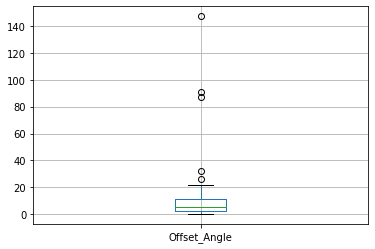

ID  Offset_Angle
141   4     147.36850
648  19      87.40706
721  21      90.75266

None

Outliers for column: Amount_of_Grabs


ID  Amount_of_Grabs
142   4               12
347  10                8
485  14               14
486  14               16
495  14                8
648  19               10

None

Outliers for column: Duration_grabbed


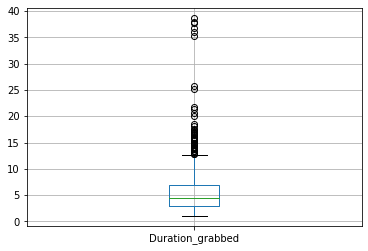

ID  Duration_grabbed
0     1         38.599120
10    1         36.737425
142   4         35.928955
180   6         21.807647
199   6         25.222294
485  14         37.705690
486  14         37.919557
613  18         20.644379
648  19         35.172332
659  19         25.800784
712  20         21.379760
719  21         20.041443

None

Outliers for column: Duration_First_Grab_Until_Last_Release


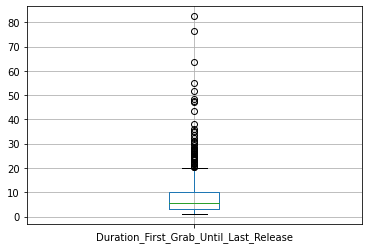

ID  Duration_First_Grab_Until_Last_Release
0     1                                 47.5325
10    1                                 47.0196
115   4                                 63.5630
142   4                                 51.6210
180   6                                 43.4225
189   6                                 48.3552
227   7                                 35.0428
347  10                                 34.9228
485  14                                 76.6490
486  14                                 82.4870
495  14                                 38.0650
648  19                                 55.1312
712  20                                 36.2440

None

Outliers for column: Duration_Ungrabbed_Inbetween


ID  Duration_Ungrabbed_Inbetween
64    2                     17.248823
74    3                     19.046805
115   4                     47.942090
126   4                     22.775788
180   6                     21.614853
189   6                     32.221778
223   7                     17.226169
227   7                     25.090072
347  10                     18.347239
485  14                     38.943310
486  14                     44.567444
495  14                     25.809384
500  14                     16.973980
625  18                     18.128167
648  19                     19.958868

None

After removal, the dataset is 95.76158940397352% of its original size. Before removal it had 755 rows, now it has 723 rows, meaning there were 32 rows with outliers. A total of 58 specific cases were found, distributed within those 32 rows removed.


ID Task Condition  Timestamp Item_name  Distance_Offset  Offset_Angle  \
0     1   A     Binary   425.4714   13 Soup         0.013511      1.742660   
1     1   A     Binary   435.0327   14 Soup         0.059544      2.432872   
2     1   A     Binary   450.6277   15 Soup         0.008105      5.307749   
3     1   A     Binary   467.4269   16 Soup         0.006684      3.656411   
4     1   A     Binary   487.5358   17 Soup         0.008042      0.952847   
..   ..  ...       ...        ...       ...              ...           ...   
750  21   B      Fixed  1191.2280   6 Milk          0.026043      8.967509   
751  21   B      Fixed  1203.3990    2 Book         0.017146      2.119605   
752  21   B      Fixed  1213.1370   12 Soup         0.008174      9.397224   
753  21   B      Fixed  1221.6030   11 Soup         0.010986      8.036102   
754  21   B      Fixed  1225.9800    9 Soup         0.004027      5.366576   

     Total_Duration_until_placement  Duration_Fixed  Duration_loose  \
0                        236.336800       25.005100      114.902200   
1                          9.060638        1.158936        4.241455   
2                         15.094360        3.646698        8.220032   
3                         16.298370        3.068451        5.310211   
4                         19.608150        7.649475        5.239685   
..                              ...             ...             ...   
750                       14.081050        0.000000        8.713867   
751                       11.670650        0.000000        5.914551   
752                        9.238037        0.000000        5.045410   
753                        7.964722        0.000000        2.575806   
754                        3.876587        0.000000        2.111450   

     Avg_Heuristic_Score  First_Grab_Timestamp  Last_Release_Timestamp  \
0                  1.875              377.3407                424.8732   
1                  0.500              428.7390                434.1394   
2                  1.500              438.1832                450.0499   
3                  1.500              458.3821                466.7608   
4                  1.500              471.8270                486.8709   
..                   ...                   ...                     ...   
750                1.625             1178.3140               1190.4250   
751                1.000             1193.3370               1202.8480   
752                2.500             1206.0690               1212.6030   
753                5.000             1218.2490               1220.8240   
754                1.500             1223.2680               1225.3800   

     Duration_grabbed  Amount_of_Grabs Task_Order Condition_Order  \
0           38.599120                5   A then B    Bin then Fix   
1            5.400391                1   A then B    Bin then Fix   
2           11.866730                1   A then B    Bin then Fix   
3            8.378662                1   A then B    Bin then Fix   
4           12.889160                2   A then B    Bin then Fix   
..                ...              ...        ...             ...   
750          8.713867                4   A then B    Bin then Fix   
751          5.914550                3   A then B    Bin then Fix   
752          5.045410                2   A then B    Bin then Fix   
753          2.575806                1   A then B    Bin then Fix   
754          2.111450                1   A then B    Bin then Fix   

     Theoretical_Start_Timestamp  Duration_total_ungrabbed  \
0                     188.634600                197.737680   
1                     425.472062                  3.660247   
2                     435.033340                  3.227630   
3                     450.628530                  7.919708   
4                     467.427650                  6.718990   
..                           ...                       ...   
750                  1176.646950                  5.367183   
7

In [14]:
# save pre-removal length
old_len = len(logs)

#get rows with values in the column that do not lie within 3xIQR
def get_outliers(df, column):
    return df[np.abs(df[column]-df[column].mean()) > (3*df[column].std())]

# create a list of all columns that will be checked for outliers
columns_to_remove_outliers_from = ['Distance_Offset', 'Offset_Angle', 'Amount_of_Grabs', 'Duration_grabbed', 'Duration_First_Grab_Until_Last_Release', 'Duration_Ungrabbed_Inbetween'] 

# create a new dataframe that keeps all rows containing outliers
logs_outliers = pd.DataFrame(columns = logs.columns)

# go through the selected columns and display the outliers found
for c in columns_to_remove_outliers_from:
    new_outliers = get_outliers(logs, c)
    print("Outliers for column: " + c)
    logs.boxplot(column=[c])
    display(new_outliers[['ID', c]], plt.show())
    logs_outliers = pd.concat([logs_outliers, new_outliers])

# Add a column that tells whether a row is an outlier or not (yes,could be more elegant)
logs['is_outlier'] = False
for index, row in logs_outliers.iterrows():
    if index in logs.index:
        logs.loc[index,'is_outlier'] = True

# save a cleaned version for the small summary output below
logs_without_outliers = logs.drop(logs_outliers.index)
print("After removal, the dataset is " + str(100 * len(logs_without_outliers)/old_len) + "% of its original size. Before removal it had " + str(old_len) + " rows, now it has " + str(len(logs_without_outliers)) + " rows, meaning there were " + str(old_len - len(logs_without_outliers)) + " rows with outliers. A total of " + str(len(logs_outliers)) + " specific cases were found, distributed within those " + str(old_len - len(logs_without_outliers)) + " rows removed.")    

# export to csv
logs.to_csv('logs.csv', sep = ';')
logs

# Merge logs pairwise and with demographics

In [25]:
logs_paired_fixed_binary = mergePairwise(logs, merge_on=["ID", "Item_name"], split_by='Condition')

# Merge with demographics
logs_paired_fixed_binary = logs_paired_fixed_binary.merge(demo, left_on=['ID'], right_on=['participantID'])

In [26]:
# export to csv
logs_paired_fixed_binary.to_csv('logs_paired.csv', sep = ';')
logs_paired_fixed_binary

ID Task_fixed  Timestamp_fixed Item_name  Distance_Offset_fixed  \
0     1         A          1605.447   13 Soup               0.005540   
1     1         A          1612.475   14 Soup               0.008495   
2     1         A          1620.047   15 Soup               0.004760   
3     1         A          1627.290   16 Soup               0.008559   
4     1         A          1646.780   17 Soup               0.004849   
..   ..        ...              ...       ...                    ...   
372  21         B          1191.228   6 Milk                0.026043   
373  21         B          1203.399    2 Book               0.017146   
374  21         B          1213.137   12 Soup               0.008174   
375  21         B          1221.603   11 Soup               0.010986   
376  21         B          1225.980    9 Soup               0.004027   

     Offset_Angle_fixed  Total_Duration_until_placement_fixed  \
0              0.682993                            884.795400   
1              5.644886                              6.528320   
2              1.057203                              7.071289   
3              3.275628                              6.741943   
4              4.479315                             18.988650   
..                  ...                                   ...   
372            8.967509                             14.081050   
373            2.119605                             11.670650   
374            9.397224                              9.238037   
375            8.036102                              7.964722   
376            5.366576                              3.876587   

     Duration_Fixed_fixed  Duration_loose_fixed  Avg_Heuristic_Score_fixed  \
0                     0.0              8.244751                      1.500   
1                     0.0              3.689209                      5.000   
2                     0.0              4.387329                      1.250   
3                     0.0              4.176270                      1.500   
4                     0.0              5.043579                      1.500   
..                    ...                   ...                        ...   
372                   0.0              8.713867                      1.625   
373                   0.0              5.914551                      1.000   
374                   0.0              5.045410                      2.500   
375                   0.0              2.575806                      5.000   
376                   0.0              2.111450                      1.500   

     First_Grab_Timestamp_fixed  Last_Release_Timestamp_fixed  \
0                      1596.604                      1604.849   
1                      1608.182                      1611.871   
2                      1615.337                      1619.471   
3                      1622.472                      1626.648   
4                      1641.137                      1646.181   
..                          ...                           ...   
372                    1178.314                      1190.425   
373                    1193.337                      1202.848   
374                    1206.069                      1212.603   
375                    1218.249                      1220.824   
376                    1223.268                      1225.380   

     Duration_grabbed_fixed  Amount_of_Grabs_fixed Task_Order Condition_Order  \
0                  8.244751                      1   A then B    Bin then Fix   
1                  3.689209                      1   A then B    Bin then Fix   
2                  4.133911                      1   A then B    Bin then Fix   
3                  4.176270                      1   A then B    Bin then Fix   
4                  5.043579                      1   A then B    Bin then Fix   
..                      ...                    ...        ...             ...   
372                8.713867                      4   A then B    Bin then 

# Log data plausibility checks

#### Records with single grab should have no 'in between' time 
If the data is checked for the value 0.0001 (one order of magnitude smaller) we get our first hits

In [16]:
logs.query('Amount_of_Grabs == 1 & Duration_Ungrabbed_Inbetween > 0.001')

Empty DataFrame
Columns: [ID, Task, Condition, Timestamp, Item_name, Distance_Offset, Offset_Angle, Total_Duration_until_placement, Duration_Fixed, Duration_loose, Avg_Heuristic_Score, First_Grab_Timestamp, Last_Release_Timestamp, Duration_grabbed, Amount_of_Grabs, Task_Order, Condition_Order, Theoretical_Start_Timestamp, Duration_total_ungrabbed, Item_Start_Timestamp, Inactive_Duration, last_grab_until_placement_duration, Duration_Ungrabbed_Inbetween, Duration_First_Grab_Until_Last_Release, is_outlier]
Index: []

#### Records with 2 or more grasps should not have a very little time in between those grasps

In [17]:
logs.query('Amount_of_Grabs > 1 & Duration_Ungrabbed_Inbetween < 0.1')#[['Amount_of_Grabs','Duration_Ungrabbed_Inbetween']]

Empty DataFrame
Columns: [ID, Task, Condition, Timestamp, Item_name, Distance_Offset, Offset_Angle, Total_Duration_until_placement, Duration_Fixed, Duration_loose, Avg_Heuristic_Score, First_Grab_Timestamp, Last_Release_Timestamp, Duration_grabbed, Amount_of_Grabs, Task_Order, Condition_Order, Theoretical_Start_Timestamp, Duration_total_ungrabbed, Item_Start_Timestamp, Inactive_Duration, last_grab_until_placement_duration, Duration_Ungrabbed_Inbetween, Duration_First_Grab_Until_Last_Release, is_outlier]
Index: []

#### Records with zero grabs should not exist

In [18]:
logs.query('Amount_of_Grabs <= 0')

Empty DataFrame
Columns: [ID, Task, Condition, Timestamp, Item_name, Distance_Offset, Offset_Angle, Total_Duration_until_placement, Duration_Fixed, Duration_loose, Avg_Heuristic_Score, First_Grab_Timestamp, Last_Release_Timestamp, Duration_grabbed, Amount_of_Grabs, Task_Order, Condition_Order, Theoretical_Start_Timestamp, Duration_total_ungrabbed, Item_Start_Timestamp, Inactive_Duration, last_grab_until_placement_duration, Duration_Ungrabbed_Inbetween, Duration_First_Grab_Until_Last_Release, is_outlier]
Index: []

#### There should be no records with a very quick (less than 1s) placement time

In [19]:
logs.query('Total_Duration_until_placement < 1.0')

Empty DataFrame
Columns: [ID, Task, Condition, Timestamp, Item_name, Distance_Offset, Offset_Angle, Total_Duration_until_placement, Duration_Fixed, Duration_loose, Avg_Heuristic_Score, First_Grab_Timestamp, Last_Release_Timestamp, Duration_grabbed, Amount_of_Grabs, Task_Order, Condition_Order, Theoretical_Start_Timestamp, Duration_total_ungrabbed, Item_Start_Timestamp, Inactive_Duration, last_grab_until_placement_duration, Duration_Ungrabbed_Inbetween, Duration_First_Grab_Until_Last_Release, is_outlier]
Index: []

In [20]:
logs.query('Duration_grabbed < 1.0')

Empty DataFrame
Columns: [ID, Task, Condition, Timestamp, Item_name, Distance_Offset, Offset_Angle, Total_Duration_until_placement, Duration_Fixed, Duration_loose, Avg_Heuristic_Score, First_Grab_Timestamp, Last_Release_Timestamp, Duration_grabbed, Amount_of_Grabs, Task_Order, Condition_Order, Theoretical_Start_Timestamp, Duration_total_ungrabbed, Item_Start_Timestamp, Inactive_Duration, last_grab_until_placement_duration, Duration_Ungrabbed_Inbetween, Duration_First_Grab_Until_Last_Release, is_outlier]
Index: []

#### Specific columns should never be below 0

In [21]:
columns_to_check = ['Distance_Offset', 'Offset_Angle', 'Total_Duration_until_placement', 'Duration_grabbed', 'Duration_Fixed',
                    'Duration_loose', 'Duration_total_ungrabbed', 'Inactive_Duration', 'Duration_First_Grab_Until_Last_Release', 'Duration_Ungrabbed_Inbetween' ]
for i in columns_to_check:
    result = logs.query(i +' < -0.001')
    if len(result) > 0: display(result[i])

## What is happening with the Ungrabbed Inbetween values? (FIXED)

The problem seems to be that the grabbed duration is not correctly measured when the very first item after the playground after starting the scene is placed. The resetFields() method in the loggingManager is only called after a successful placement. In the playground phase a lot of items are grabbed and the grabbed duration counter rises and rises and is never reset before the actual experiment items get placed. Only if the last item grabbed in the playground gets placed into a goal zone the counter is reset and the value should be right, which isn the case most of the time.

Solution: Reconstruct the grabbed time from the logs: all 'Released' Messages contain a correct duration for the grabbed time, so these values should be summed up and all affected values (working with grabbed duration) should be recalculated. It should be checked whether the values differ from the initial values recorded for all other cases as well. In case the scene has had to be restarted because of a crash, the first value will be affected as well.

Unfortunately the fixed and loose durations are also affected from this programming mistake but cant be reconstructred from the logs so at least every first placement record is unusable.#
Still in theory only half of the beginnings should be affected because approximately half of them should have started in fixed mode anyway, therefore this distinction between fixed and loose is invalid anyway. 

In [22]:
logs.query('Distance_Offset > 0.03 and Distance_Offset < 0.05')[['ID', 'Distance_Offset']]

ID  Distance_Offset
25    1         0.035818
54    2         0.045775
122   4         0.042239
125   4         0.034246
132   4         0.041284
147   5         0.038083
155   5         0.032647
173   5         0.037111
175   5         0.038739
206   6         0.030418
222   7         0.047896
239   7         0.034070
243   7         0.039424
316   9         0.031737
324  10         0.037133
333  10         0.034010
376  11         0.035150
393  11         0.030332
448  13         0.030238
467  14         0.043083
472  14         0.049013
483  14         0.033613
494  14         0.032135
500  14         0.033362
501  14         0.033300
506  15         0.034070
510  15         0.032709
521  15         0.031882
528  15         0.035256
544  16         0.032861
551  16         0.046801
566  16         0.032538
569  16         0.039627
571  16         0.032363
585  17         0.038306
616  18         0.040100
628  18         0.032789
652  19         0.030914
654  19         0.036586
656  19         0.041205
670  19         0.044866
705  20         0.039754
711  20         0.036926
730  21         0.033289
735  21         0.042352

In [23]:
logs['Duration_Ungrabbed_Inbetween'].plot.hist(bins=30)

<AxesSubplot:ylabel='Frequency'>